## Project description

Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.
The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.
The model will help to optimize the production and eliminate unprofitable parameters.

### Project instructions
- 1. Prepare the data
    - 1.1. Open the files and look into the data.
    - 1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
    - 1.3. Analyze the features not available in the test set. What are these parameters? What is their type?
    - 1.4. Perform data preprocessing.
- 2. Analyze the data
    - 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
    - 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
    - 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.
- 3. Build the model
    - 3.1. Write a function to calculate the final sMAPE value.
    - 3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

### Data description
Technological process
- Rougher feed — raw material
- Rougher additions (or reagent additions) — flotation reagents: ---Xanthate, Sulphate, Depressant
    - Xanthate — promoter or flotation activator;
    - Sulphate — sodium sulphide for this particular process;
    - Depressant — sodium silicate.
- Rougher process — flotation
- Rougher tails — product residues
- Float banks — flotation unit
- Cleaner process — purification
- Rougher Au — rougher gold concentrate
- Final Au — final gold concentrate

Parameters of stages
- air amount — volume of air
- fluid levels
- feed size — feed particle size
- feed rate

#### Feature naming

Here's how you name the features:
[stage].[parameter_type].[parameter_name]
Example: rougher.input.feed_ag
Possible values for [stage]:
- rougher — flotation
- primary_cleaner — primary purification
- secondary_cleaner — secondary purification
- final — final characteristics

Possible values for [parameter_type]:
- input — raw material parameters
- output — product parameters
- state — parameters characterizing the current state of the stage
- calculation — calculation characteristics



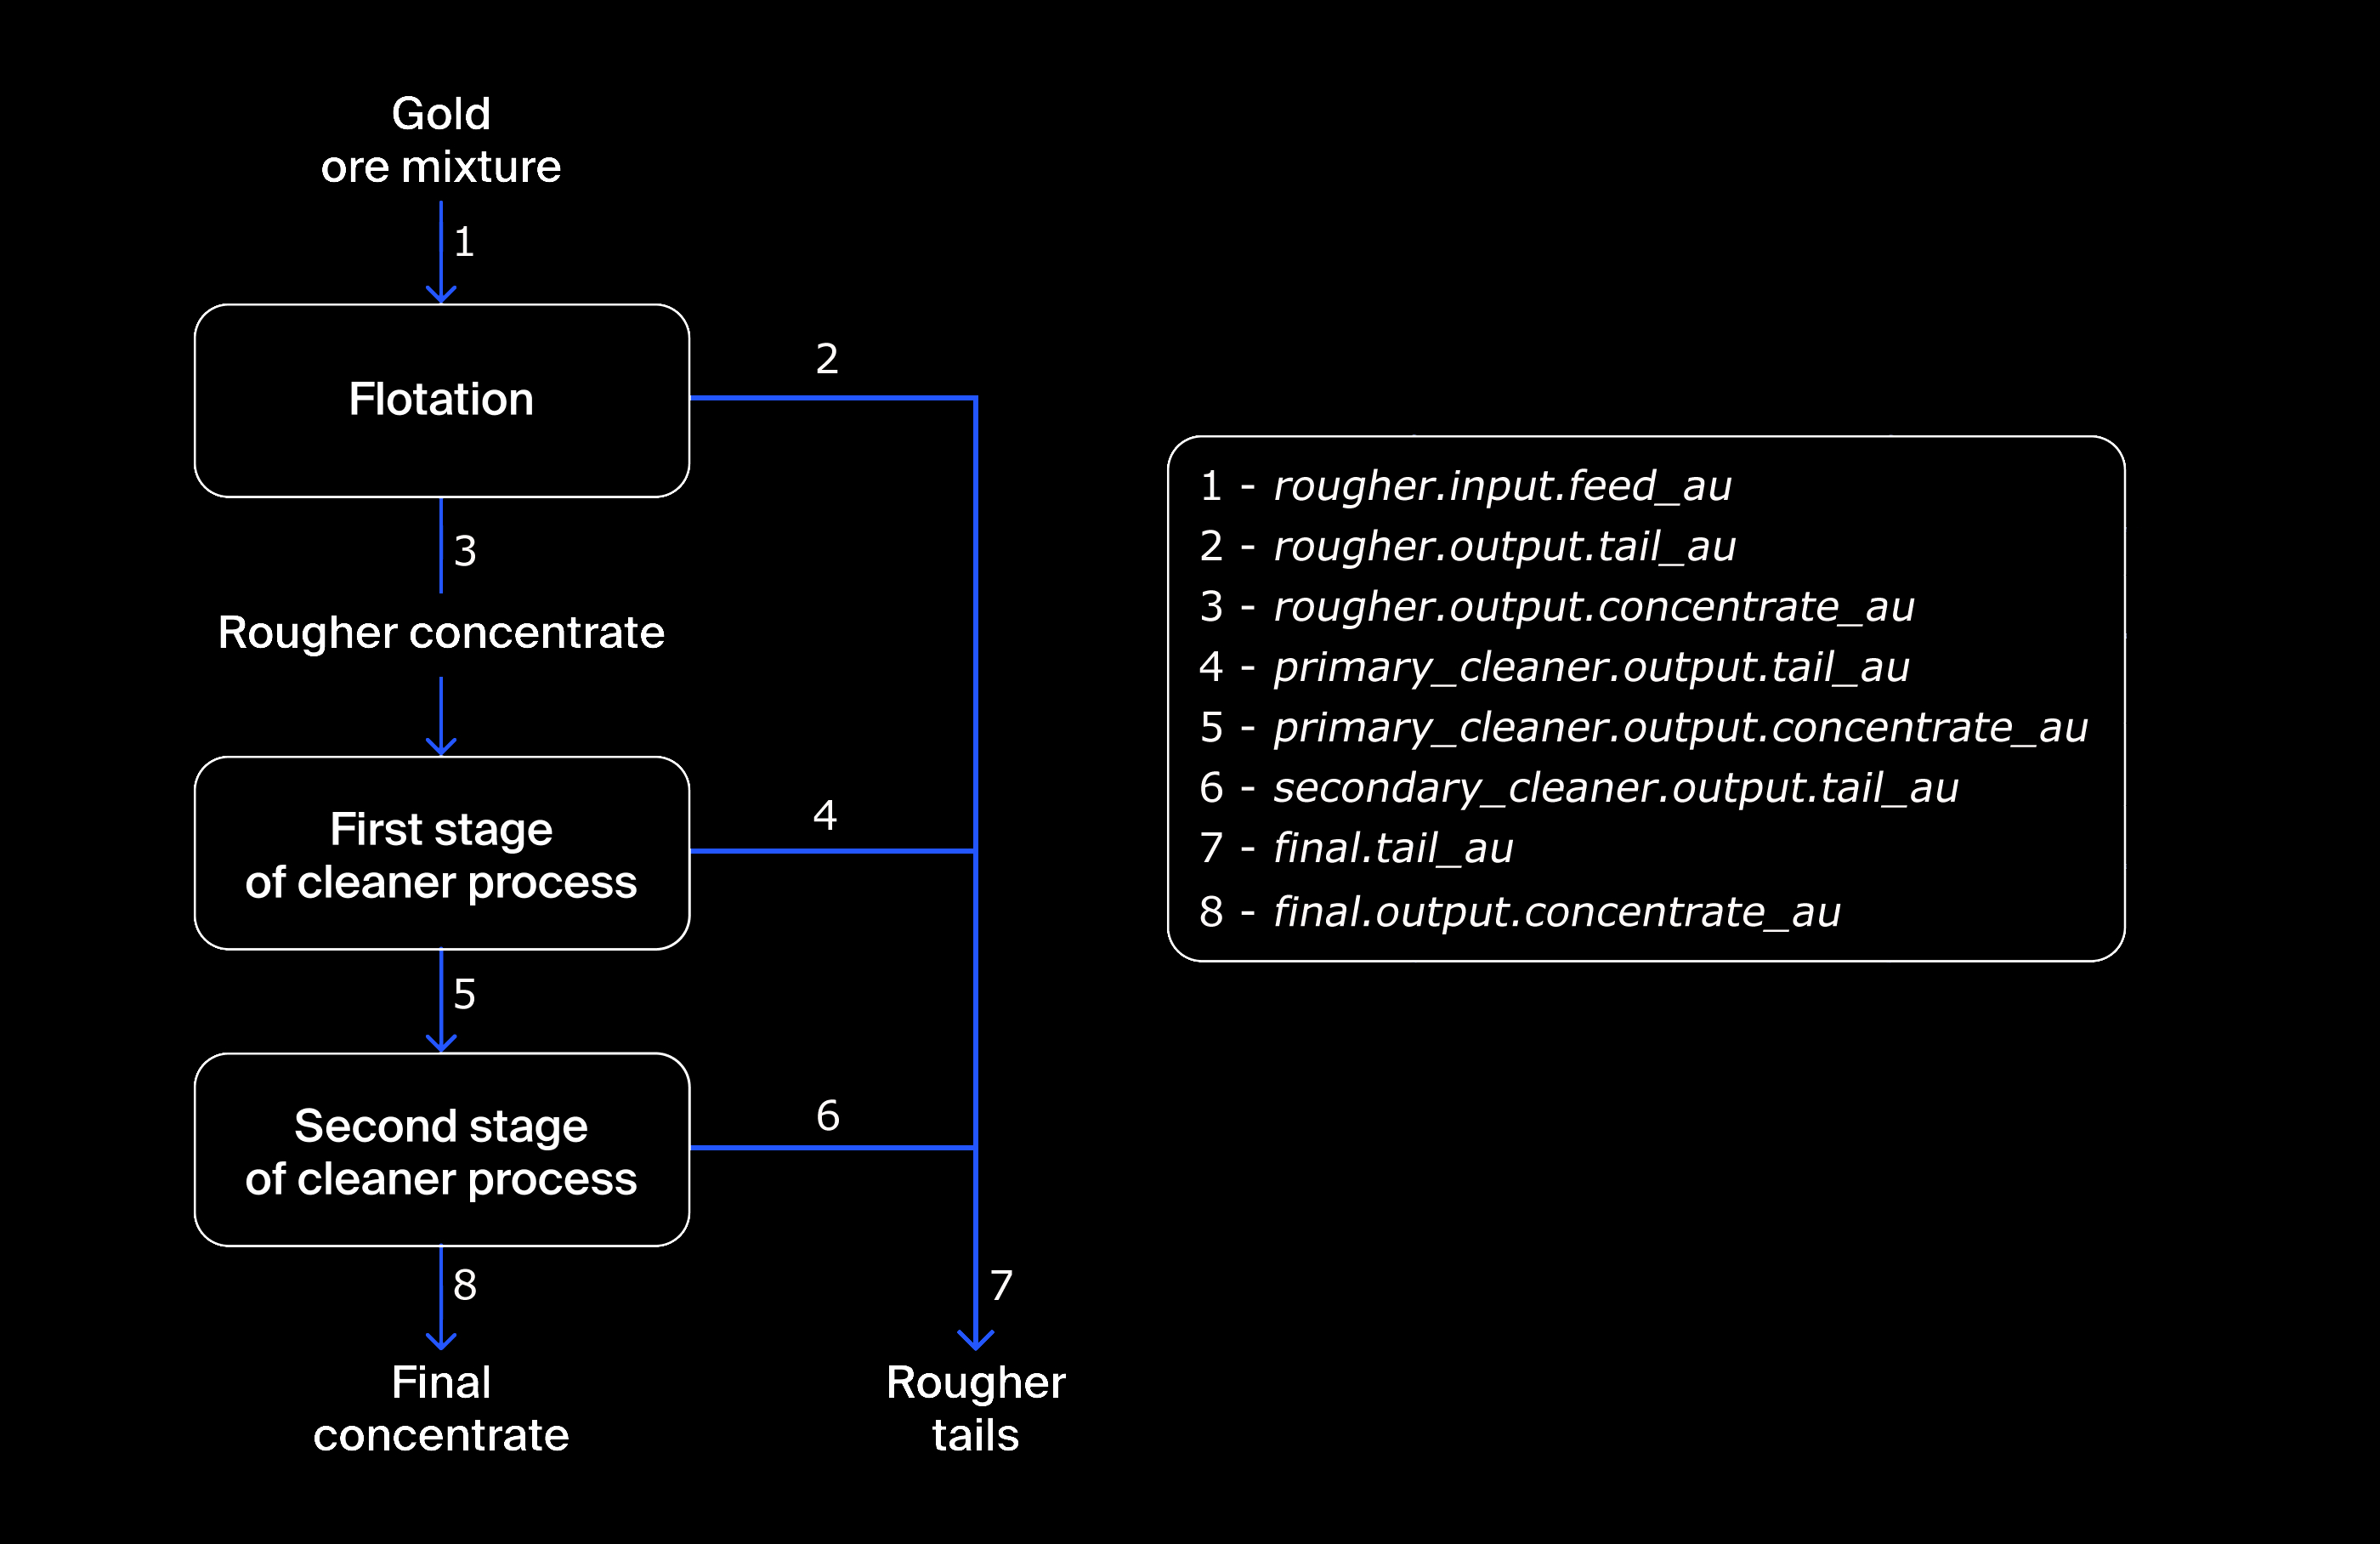

## Data Preprocessing

In [1]:
# Initialize packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor


import warnings
warnings.filterwarnings('ignore')

# constant variables
state = np.random.RandomState(12345)
TARGET1 = 'rougher.output.recovery'
TARGET2 = 'final.output.recovery'
TARGETS=[TARGET1,TARGET2]


In [2]:
# Load datasets into notebook

recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
recovery_source = pd.read_csv('/datasets/gold_recovery_full.csv')


In [3]:
# Make lists of dataframes for processing of dataframes
# df_stt is source, training, test datasets

df_stt = [recovery_train,recovery_test,recovery_source]
df_stt_names=['recovery_train','recovery_test','recovery_source']


# Get dataset information
def display_information(df):
    print("Shape:",df.shape)
    print()
    print('Sample:')
    print()
    display(df.head())
    print()
    print('Describe:')
    print()
    display(df.describe())
    missing_values(df,5)
    print('Duplicated:')
    print( 'We have {} duplicated rows.'.format(df.duplicated().sum()))
    print()

# Get missing values   
def missing_values(df,num):
    print("Missing values:")
    df_nulls = df.isna().sum()
    df_nulls = pd.DataFrame(round(df_nulls,num),columns=['Missing Values'])
    df_nulls['Percent of Nulls']= round(df.isna().mean(),num) * 100   
    
    #return df_nulls
    display(df_nulls)

    
# Run function on all datasets
for i in range(3):
    print("Dataset Name: ",df_stt_names[i])
    display_information(df_stt[i])
    
    
    

Dataset Name:  recovery_train
Shape: (16860, 87)

Sample:



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Describe:



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


Missing values:


,Missing Values,Percent of Nulls
date,0,0.000
final.output.concentrate_ag,72,0.427
final.output.concentrate_pb,72,0.427
final.output.concentrate_sol,370,2.195
final.output.concentrate_au,71,0.421
...,...,...
secondary_cleaner.state.floatbank5_a_level,85,0.504
secondary_cleaner.state.floatbank5_b_air,85,0.504
secondary_cleaner.state.floatbank5_b_level,84,0.498
secondary_cleaner.state.floatbank6_a_air,103,0.611


Duplicated:
We have 0 duplicated rows.

Dataset Name:  recovery_test
Shape: (5856, 53)

Sample:



,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333



Describe:



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


Missing values:


,Missing Values,Percent of Nulls
date,0,0.000
primary_cleaner.input.sulfate,302,5.157
primary_cleaner.input.depressant,284,4.850
primary_cleaner.input.feed_size,0,0.000
primary_cleaner.input.xanthate,166,2.835
primary_cleaner.state.floatbank8_a_air,16,0.273
primary_cleaner.state.floatbank8_a_level,16,0.273
primary_cleaner.state.floatbank8_b_air,16,0.273
primary_cleaner.state.floatbank8_b_level,16,0.273
primary_cleaner.state.floatbank8_c_air,16,0.273


Duplicated:
We have 0 duplicated rows.

Dataset Name:  recovery_source
Shape: (22716, 87)

Sample:



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Describe:



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


Missing values:


,Missing Values,Percent of Nulls
date,0,0.000
final.output.concentrate_ag,89,0.392
final.output.concentrate_pb,87,0.383
final.output.concentrate_sol,385,1.695
final.output.concentrate_au,86,0.379
...,...,...
secondary_cleaner.state.floatbank5_a_level,101,0.445
secondary_cleaner.state.floatbank5_b_air,101,0.445
secondary_cleaner.state.floatbank5_b_level,100,0.440
secondary_cleaner.state.floatbank6_a_air,119,0.524


Duplicated:
We have 0 duplicated rows.



### Check that recovery is calculated correctly. 
Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.




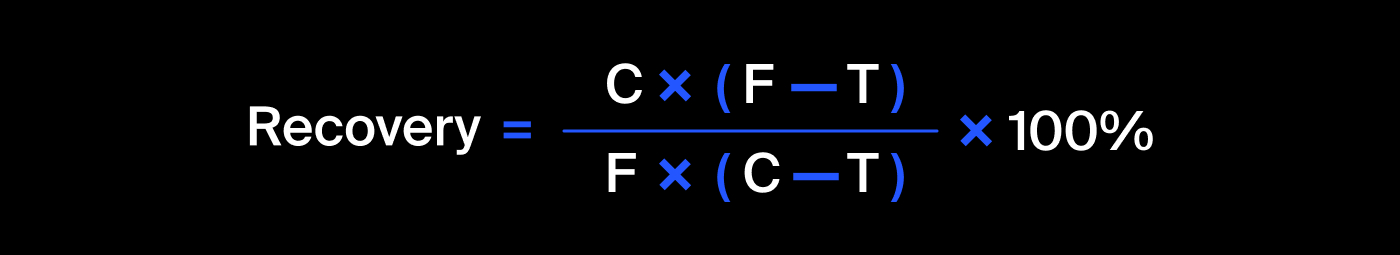

In [4]:
# Creating new dataframe with relevant columns for recovery calculation
data = recovery_train['rougher.output.recovery'],recovery_train['rougher.output.concentrate_au'], recovery_train['rougher.input.feed_au'], recovery_train['rougher.output.tail_au'],
headers = ['rougher.output.recovery','rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']
new_df = pd.concat(data,axis=1,keys=headers)
new_df = new_df.dropna()
display(new_df)

,rougher.output.recovery,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
0,87.107763,19.793808,6.486150,1.170244
1,86.843261,20.050975,6.478583,1.184827
2,86.842308,19.737170,6.362222,1.162562
3,87.226430,19.320810,6.118189,1.079755
4,86.688794,19.216101,5.663707,1.012642
...,...,...,...,...
16855,89.574376,18.603550,5.335862,0.748633
16856,87.724007,18.441436,4.838619,0.771582
16857,88.890579,15.111231,4.525061,0.685059
16858,89.858126,17.834772,4.362781,0.567130


In [5]:
# Recovery function

def recoveryCalculation(C_rougher, F_rougher, T_rougher):
    recovery = (C_rougher * (F_rougher - T_rougher)) / (F_rougher * (C_rougher - T_rougher)) * 100
    print(recovery)
    return recovery

recovery = recoveryCalculation(new_df['rougher.output.concentrate_au'],new_df['rougher.input.feed_au'], new_df['rougher.output.tail_au'])

  



0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 14287, dtype: float64


In [6]:
# Mean absolute error 

mae = mean_absolute_error(new_df['rougher.output.recovery'].dropna(),recovery)
print(mae)

9.303415616264301e-15


The mean absolute error is 9.3e-15 which is very small, indicating that the feature values in the data are very accurate.

###  Analyze the features not available in the test set. What are these parameters? What is their type?

In [7]:
# Saving different columns to new variable

different_columns = set(recovery_train.columns).symmetric_difference(recovery_test.columns)
print(different_columns)
print()
print('Number of features not available in the test set:', len(different_columns))



{'secondary_cleaner.output.tail_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.tail_pb', 'final.output.recovery', 'rougher.output.tail_pb', 'final.output.concentrate_pb', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_sol', 'rougher.output.tail_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_sol', 'secondary_cleaner.output.tail_ag', 'final.output.concentrate_au', 'final.output.tail_au', 'primary_cleaner.output.tail_ag', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.output.recovery', 'final.output.tail_pb', 'primary_cleaner.output.concentrate_au', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.tail_sol', 'final.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'final.output.tail_ag', 'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_pb', 'final.output.concentrate_sol', 'rougher.output.conce

In [8]:
# Creating a df to store those columns to be able to display the data types. Just copy and paste of the list obtained.

differences = recovery_train[['rougher.output.tail_au', 'rougher.output.tail_sol', 'final.output.concentrate_au', 'rougher.output.concentrate_au', 'final.output.concentrate_ag', 'secondary_cleaner.output.tail_pb', 'final.output.concentrate_pb', 'primary_cleaner.output.concentrate_au', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'secondary_cleaner.output.tail_ag', 'primary_cleaner.output.concentrate_pb', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'final.output.tail_pb', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'rougher.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_sol', 'rougher.output.recovery', 'secondary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_sol', 'rougher.output.concentrate_ag', 'final.output.tail_sol', 'rougher.output.concentrate_pb', 'final.output.recovery', 'rougher.calculation.au_pb_ratio', 'final.output.tail_ag', 'final.output.concentrate_sol', 'rougher.calculation.sulfate_to_au_concentrate']]
print(differences.dtypes)



rougher.output.tail_au                                float64
rougher.output.tail_sol                               float64
final.output.concentrate_au                           float64
rougher.output.concentrate_au                         float64
final.output.concentrate_ag                           float64
secondary_cleaner.output.tail_pb                      float64
final.output.concentrate_pb                           float64
primary_cleaner.output.concentrate_au                 float64
rougher.calculation.floatbank10_sulfate_to_au_feed    float64
rougher.calculation.floatbank11_sulfate_to_au_feed    float64
secondary_cleaner.output.tail_ag                      float64
primary_cleaner.output.concentrate_pb                 float64
rougher.output.tail_ag                                float64
rougher.output.tail_pb                                float64
final.output.tail_pb                                  float64
final.output.tail_au                                  float64
primary_

The parameters are output values at different stages for various metals. The output values are not necessary for the machine learning model training and testing.



### Perform data preprocessing.


In [9]:


# Printing out the sum of NaNs remained.
print('NaNs in gold_train:', recovery_train.isna().sum().sum())
print('NaNs in gold_test:', recovery_test.isna().sum().sum())




NaNs in gold_train: 30320
NaNs in gold_test: 2360


In [10]:
# Eliminating all NaNs from the datasets.

recovery_train = recovery_train.dropna()
recovery_test = recovery_test.dropna()

recovery_source_merge = recovery_source[["date", "rougher.output.recovery", "final.output.recovery", "rougher.output.concentrate_au", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb", "rougher.output.concentrate_sol", "final.output.concentrate_au", "final.output.concentrate_ag", "final.output.concentrate_pb", "final.output.concentrate_sol"]]

recovery_test = recovery_test.merge(recovery_source_merge, on="date", how="left")

recovery_source_merge = recovery_source_merge.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

recovery_train = recovery_train.drop("date", axis=1)
recovery_test = recovery_test.drop("date", axis=1)
recovery_source = recovery_source.drop("date", axis=1)
recovery_train = recovery_train.dropna()
recovery_test = recovery_test.dropna()
print('NaNs in gold_train:', recovery_train.isna().sum().sum())
print('NaNs in gold_test:', recovery_test.isna().sum().sum())


NaNs in gold_train: 0
NaNs in gold_test: 0


In [11]:
for df in [recovery_source, recovery_train, recovery_test]:
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df.set_index("date", inplace=True)


### Conclusion

We have three datasets, a full datasets, a training and a test dataset. Those are already splitted from the full.

- The full dataset is composed by 22715 rows and 87 columns.
- The training dataset instead by 16860 rows and 87 columns.
- The test dataset is composed by 5856 rows and 53 columns.

Merging the training and test dataset we obtain the full one. From the TEST dataset are missing output and calculation columns (34 missing columns).

The mean absolute error is 9.3e-15 which is very small, indicating that the feature values in the data are very accurate.

Filled missing values using ffill(). Added required info to test dataframe from full dataframe and removed date columns which are not needed for the model fitting.



Training data shape: (11017, 87)
Testing data shape: (5383, 53)

## Analyze the data 
### Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.


In [12]:
# Calculating mean for every interested column.

print('Concentration before purification stage:')
print('The mean of concentrate Au after floatation stage is:', recovery_train['rougher.output.concentrate_au'].mean().round(2))
print('The mean of concentrate Ag after floatation stage is:', recovery_train['rougher.output.concentrate_ag'].mean().round(2))
print('The mean of concentrate Pb after floatation stage is:', recovery_train['rougher.output.concentrate_pb'].mean().round(2))
print()
print('Concentration after first purification stage:')
print('The mean of concentrate Au after first purification stage is:', recovery_train['primary_cleaner.output.concentrate_au'].mean().round(2))
print('The mean of concentrate Ag after first purification stage is:', recovery_train['primary_cleaner.output.concentrate_ag'].mean().round(2))
print('The mean of concentrate Pb after first purification stage is:', recovery_train['primary_cleaner.output.concentrate_pb'].mean().round(2))
print()
print('Concentration after second purification stage:')
print('The mean of concentrate Au after second purification stage is:', recovery_train['final.output.concentrate_au'].mean().round(2))
print('The mean of concentrate Ag after second purification stage is:', recovery_train['final.output.concentrate_ag'].mean().round(2))
print('The mean of concentrate P  after second purification stage is:', recovery_train['final.output.concentrate_pb'].mean().round(2))

Concentration before purification stage:
The mean of concentrate Au after floatation stage is: 19.78
The mean of concentrate Ag after floatation stage is: 11.84
The mean of concentrate Pb after floatation stage is: 7.61

Concentration after first purification stage:
The mean of concentrate Au after first purification stage is: 32.38
The mean of concentrate Ag after first purification stage is: 8.44
The mean of concentrate Pb after first purification stage is: 9.57

Concentration after second purification stage:
The mean of concentrate Au after second purification stage is: 44.13
The mean of concentrate Ag after second purification stage is: 5.16
The mean of concentrate P  after second purification stage is: 10.17


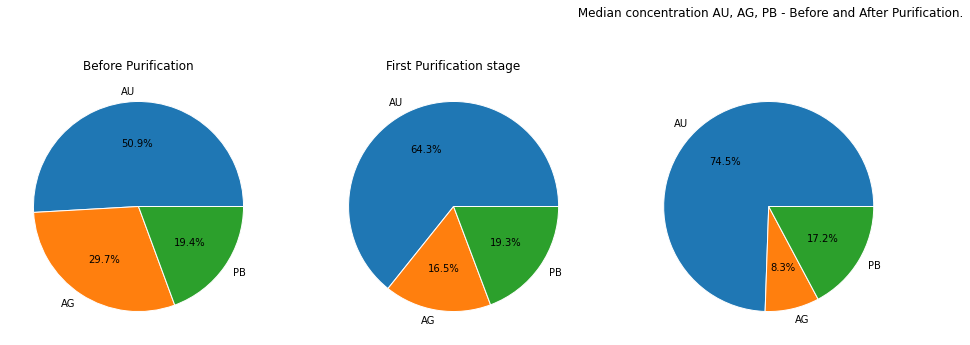

In [33]:
# Pie chart 
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,8)) #ax1,ax2 refer to your two pies

slices = [recovery_train['rougher.output.concentrate_au'].median(), recovery_train['rougher.output.concentrate_ag'].median(), recovery_train['rougher.output.concentrate_pb'].median()]
labels = ['AU','AG', 'PB']
ax1.pie(slices, labels=labels, wedgeprops = {'edgecolor': 'white'}, autopct='%1.1f%%')
ax1.set_title('Before Purification')



slices = [recovery_train['primary_cleaner.output.concentrate_au'].median(), recovery_train['primary_cleaner.output.concentrate_ag'].median(), recovery_train['primary_cleaner.output.concentrate_pb'].median()]
labels = ['AU','AG', 'PB']
ax2.pie(slices, labels=labels, wedgeprops = {'edgecolor': 'white'}, autopct='%1.1f%%')
ax2.set_title('First Purification stage')

slices = [recovery_train['final.output.concentrate_au'].median(), recovery_train['final.output.concentrate_ag'].median(), recovery_train['final.output.concentrate_pb'].median()]
labels = ['AU','AG', 'PB']
ax3.pie(slices, labels=labels, wedgeprops = {'edgecolor': 'white'}, autopct='%1.1f%%')
ax3.set_title('Second Purification Stage')

plt.title(" Median concentration AU, AG, PB - Before and After Purification.",y=1.2,loc='center')

plt.show()


In [14]:
metal_au = recovery_source[["rougher.input.feed_au", "rougher.output.concentrate_au", "primary_cleaner.output.concentrate_au", "final.output.concentrate_au"]]
metal_ag = recovery_source[["rougher.input.feed_ag", "rougher.output.concentrate_ag", "primary_cleaner.output.concentrate_ag", "final.output.concentrate_ag"]]
metal_pb = recovery_source[["rougher.input.feed_pb", "rougher.output.concentrate_pb", "primary_cleaner.output.concentrate_pb", "final.output.concentrate_pb"]]

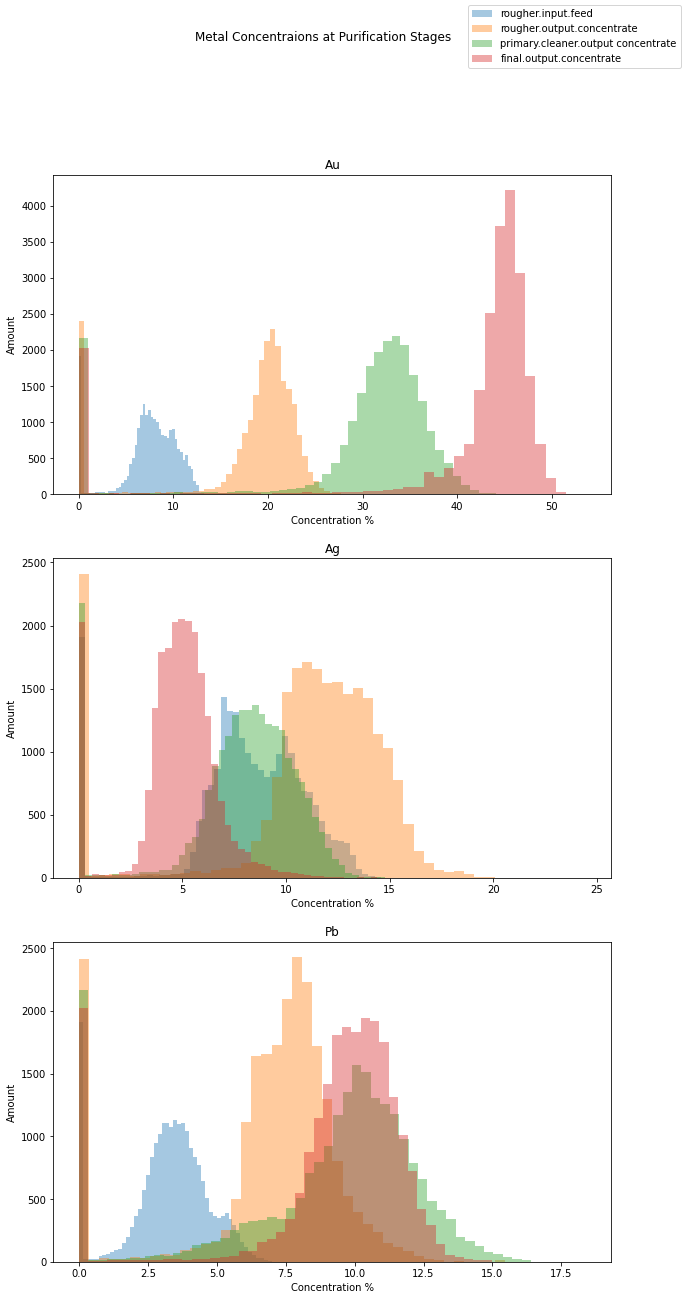

In [15]:
# Plot Au, Ag, and Pb metal concentrations at purification stage.


fig, axes = plt.subplots(3, 1, figsize=(10, 20))
for column in list(metal_au):
    sns.distplot(metal_au[column], ax=axes[0], kde=False)
axes[0].set(title="Au", xlabel="Concentration %", ylabel="Amount")
for column in list(metal_ag):
    sns.distplot(metal_ag[column], ax=axes[1], kde=False)
axes[1].set(title="Ag", xlabel="Concentration %", ylabel="Amount")
for column in list(metal_pb):
    sns.distplot(metal_pb[column], ax=axes[2], kde=False)
axes[2].set(title="Pb", xlabel="Concentration %", ylabel="Amount")
fig.suptitle("Metal Concentraions at Purification Stages")
fig.legend(["rougher.input.feed","rougher.output.concentrate", "primary.cleaner.output concentrate", "final.output.concentrate"])
fig.show()

The concentration of Au increases unifomrly throughout the purification stage. The concentraion of Ag increases and decreases slightly throughout the stage resulting in a net decrease. The concnetration of Pb increases slightly throughout the stage resulting in a net increase similar to the primary cleaner output concentrate.



### Compare the feed particle size distributions in the training set and in the test set.
If the distributions vary significantly, the model evaluation will be incorrect.


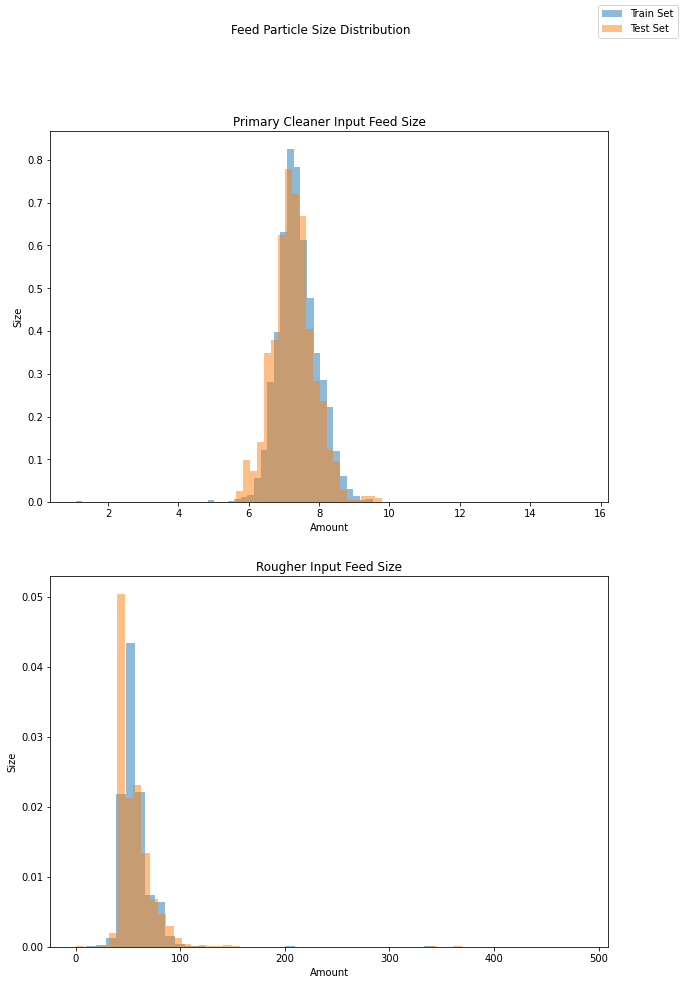

In [16]:
# Plot feed particle size distribution in train and test set.


fig, axes = plt.subplots(2,1, figsize=(10, 15))
axes[0].hist(recovery_train["primary_cleaner.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[0].hist(recovery_test["primary_cleaner.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[0].set(title="Primary Cleaner Input Feed Size", xlabel="Amount", ylabel="Size")
axes[1].hist(recovery_train["rougher.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[1].hist(recovery_test["rougher.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[1].set(title="Rougher Input Feed Size", xlabel="Amount", ylabel="Size")
fig.suptitle("Feed Particle Size Distribution")
fig.legend(["Train Set", "Test Set"])
fig.show()

The particle size distribution shows that the particles sizes do not vary siginificantly in the train and test set. Therefore the model evaluation may be correct.



### Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. 
Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

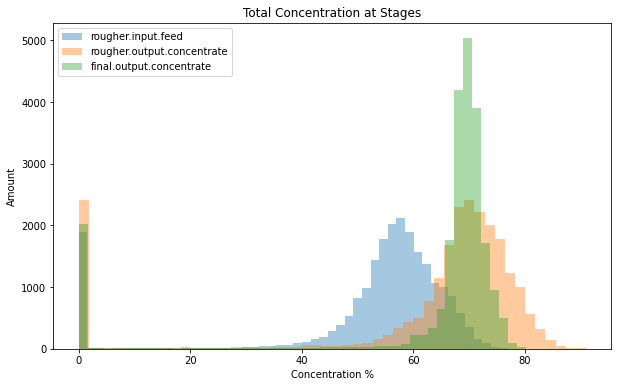

In [17]:
def raw_feed(df):
    return df["rougher.input.feed_au"] + df["rougher.input.feed_ag"] + df["rougher.input.feed_pb"] + df["rougher.input.feed_sol"]

def rougher_conc(df):
    return df["rougher.output.concentrate_au"] + df["rougher.output.concentrate_ag"] + df["rougher.output.concentrate_pb"] + df["rougher.output.concentrate_sol"]

def final_conc(df):
    return df["final.output.concentrate_au"] + df["final.output.concentrate_ag"] + df["final.output.concentrate_pb"] + df["final.output.concentrate_sol"]

recovery_source["rougher.input.feed"] = raw_feed(recovery_source)
recovery_source["rougher.output.concentrate"] = rougher_conc(recovery_source)
recovery_source["final.output.concentrate"] = final_conc(recovery_source)

total_conc = recovery_source[["rougher.input.feed", "rougher.output.concentrate", "final.output.concentrate"]]

fig = plt.figure(figsize=(10, 6))
for column in list(total_conc):
    sns.distplot(total_conc[column], kde=False)
plt.legend(list(total_conc))
plt.title("Total Concentration at Stages")
plt.xlabel("Concentration %")
plt.ylabel("Amount")
fig.show()

The concentration distributions at various stages all show abnormal values at 0%. Therefore it is worth removing these values from both samples (< 20%) to ensure accuracy in the model.

### Conclusion

The particle size distribution shows that the particles sizes do not vary siginificantly in the train and test set. Therefore the model evaluation may be correct.

The concentration distributions at various stages all show abnormal values at 0%. Therefore it is worth removing these values from both samples (< 20%) to ensure accuracy in the model.



## Build the model

###  Write a function to calculate the final sMAPE value.


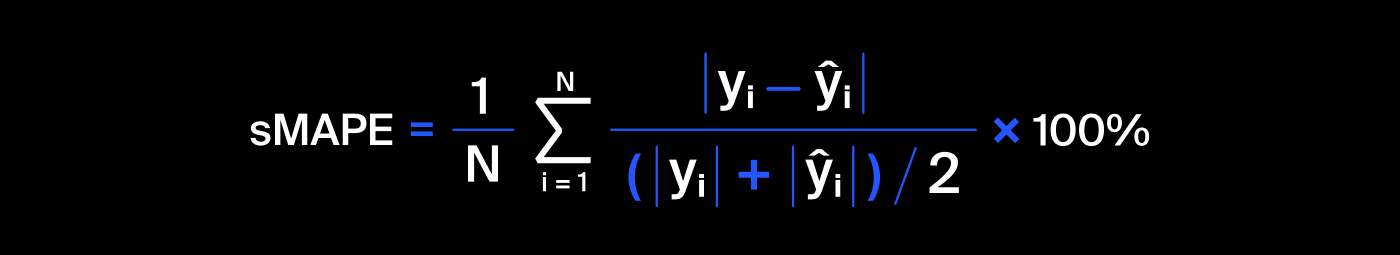




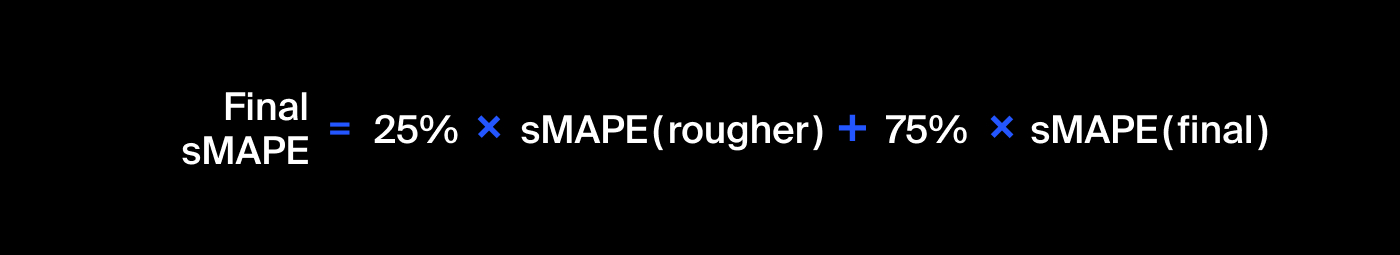

### Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

In [18]:
# Remove values less than 20

recovery_train["rougher.input.feed"] = raw_feed(recovery_train)
recovery_train["rougher.output.concentrate"] = rougher_conc(recovery_train)
recovery_train["final.output.concentrate"] = final_conc(recovery_train)

recovery_train = recovery_train[(recovery_train["rougher.input.feed"] > 20) & (recovery_train["rougher.output.concentrate"] > 20) & (recovery_train["final.output.concentrate"] > 20)]
recovery_train = recovery_train.drop(["rougher.input.feed", "rougher.output.concentrate", "final.output.concentrate"], axis=1)

In [19]:
# Remove values less than 20

recovery_test["rougher.input.feed"] = raw_feed(recovery_test)
recovery_test["rougher.output.concentrate"] = rougher_conc(recovery_test)
recovery_test["final.output.concentrate"] = final_conc(recovery_test)

recovery_test = recovery_test[(recovery_test["rougher.input.feed"] > 20) & (recovery_test["rougher.output.concentrate"] > 20) & (recovery_test["final.output.concentrate"] > 20)]
recovery_test = recovery_test.drop(["rougher.input.feed", "rougher.output.concentrate", "final.output.concentrate"], axis=1)
recovery_test = recovery_test.drop(list(recovery_source_merge.columns.values), axis=1)




In [20]:
# Define sMAPE functions
def smape(y_true, y_pred):
    frac = np.abs(np.divide(np.abs(y_true - y_pred), (np.abs(y_true)+np.abs(y_pred))/2))
    return np.abs(np.average(frac, axis=0))

def smape_final(y_true,y_pred):
    smape_out_rougher = smape(y_true[target.index('rougher.output.recovery')], y_pred[target.index('rougher.output.recovery')])
    smape_out_final = smape(y_true[target.index('final.output.recovery')], y_pred[target.index('final.output.recovery')])
    return np.abs(0.25* smape_out_rougher + 0.75* smape_out_final)


smape_score = make_scorer(smape_final,greater_is_better=False)


In [21]:
print(recovery_train.isna().sum().sum())
print(recovery_test.isna().sum().sum())

0
0


In [22]:
# Split data 
target = ['rougher.output.recovery', 'final.output.recovery']
features = list(set(recovery_train.columns).intersection(set(recovery_test.columns)).difference(set(target)))

X_train, X_test = recovery_train[features].values, recovery_test[features].values
y_train, y_test = recovery_train[target].values, recovery_test[target].values



In [23]:
# Dummy Regressor
dm = DummyRegressor(strategy='mean').fit(X_train, y_train)
y_pred = dm.predict(X_test)
print('smape:', smape_final(y_test, y_pred))


smape: 0.040783073869042744


#### Linear Regression

In [24]:
# Linear Regression

print("Linear Regression")
lr = LinearRegression().fit(X_train, y_train)
scores_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring=smape_score)
print("mean smape:", scores_lr.mean())
scores_lr

Linear Regression
mean smape: -0.058870665332066655


array([-0.05520602, -0.03941155, -0.06821849, -0.03240782, -0.09910946])

#### Decision Tree Regressor

In [25]:
# Find best paramters using GridSearchCV

params = {'min_samples_split': range(2, 6, 2),'max_depth': range(100,501,100)}
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=state),param_grid=params,scoring=smape_score, cv=5, refit=True)
g_cv.fit(X_train, y_train)
best_params = g_cv.best_params_
print(best_params)

{'max_depth': 100, 'min_samples_split': 2}


In [26]:
# Decision Tree Regressor
print("Decision Tree Regressor")

dtr = DecisionTreeRegressor(**best_params).fit(X_train, y_train)
scores_dtr = cross_val_score(dtr, X_train, y_train, cv=5, scoring=smape_score)
print("mean smape:", scores_dtr.mean())
scores_dtr

Decision Tree Regressor
mean smape: -0.06393284642357736


array([-0.16586846, -0.06241892, -0.04318058, -0.03310183, -0.01509444])

#### Random Forest Regressor

In [27]:
# Find best paramters using GridSearchCV
params = {'min_samples_split': range(2, 6, 2),'n_estimators':range(2,6,2)}
rf_cv = GridSearchCV(RandomForestRegressor(random_state=state),param_grid=params,scoring=smape_score, cv=5, refit=True)
rf_cv.fit(X_train, y_train)
best_params1 = rf_cv.best_params_
print(best_params1)


{'min_samples_split': 2, 'n_estimators': 2}


In [28]:
# Random Forest Regressor

print('Random Forest Regressor')
rfr = RandomForestRegressor(**best_params1).fit(X_train, y_train)
scores_rfr = cross_val_score(rfr, X_train, y_train, cv=5, scoring=smape_score)
print("mean smape:", scores_rfr.mean())
scores_rfr

Random Forest Regressor
mean smape: -0.051176693383184646


array([-0.19027705, -0.01255522, -0.01203157, -0.02052781, -0.02049182])

In [29]:
# Final Model
print("Final Model: Random Forest Regressor")

final_model = RandomForestRegressor(**best_params1).fit(X_train, y_train)
y_predict = dm.predict(X_test)
print('smape:', smape_final(y_test, y_pred))
#print("mean smape:", scores_final.mean())
#scores_final

Final Model: Random Forest Regressor
smape: 0.040783073869042744


### Conclusion

The concentration distributions at various stages all show abnormal values at 0%. Therefore it is worth removing these values from both samples (< 20%) to ensure accuracy in the model.

The best model observed is using the RandomForestRegressor at 2 n_setimators and 2 minimum samples split. The final sMAPE found is 0.04%. The dummy model also prediciting the mean to be 0.04% which indicates that the machine learning model is not significantly better than the dummy model prediciting the mean. 
